In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation([-30,30]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [6]:
data_dir = '../data'

image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                 for x in ['train', 'val']}

dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x:len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
class_names

['help', 'nothelp']

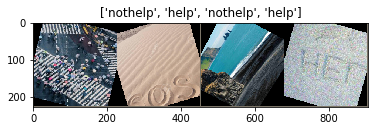

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp+mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        epoch_time = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects.double()/dataset_sizes[phase]
            epoch_elapsed = time.time()-epoch_time
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print('Epoch time: {:.0f}m {:.0f}s'.format(epoch_elapsed//60, epoch_elapsed%60))
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model
        

In [10]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0 
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6193 Acc: 0.7470
val Loss: 0.2145 Acc: 0.9110
Epoch time: 2m 56s

Epoch 1/14
----------
train Loss: 0.5000 Acc: 0.8063
val Loss: 0.4461 Acc: 0.8356
Epoch time: 3m 24s

Epoch 2/14
----------
train Loss: 0.4555 Acc: 0.8210
val Loss: 0.1413 Acc: 0.9555
Epoch time: 3m 15s

Epoch 3/14
----------
train Loss: 0.4570 Acc: 0.8186
val Loss: 0.5039 Acc: 0.8425
Epoch time: 3m 36s

Epoch 4/14
----------
train Loss: 0.4031 Acc: 0.8499
val Loss: 0.1880 Acc: 0.9349
Epoch time: 3m 13s

Epoch 5/14
----------
train Loss: 0.3310 Acc: 0.8755
val Loss: 0.1462 Acc: 0.9486
Epoch time: 2m 57s

Epoch 6/14
----------
train Loss: 0.2888 Acc: 0.8890
val Loss: 0.1343 Acc: 0.9452
Epoch time: 2m 56s

Epoch 7/14
----------
train Loss: 0.1945 Acc: 0.9251
val Loss: 0.1178 Acc: 0.9589
Epoch time: 2m 54s

Epoch 8/14
----------
train Loss: 0.1668 Acc: 0.9401
val Loss: 0.1149 Acc: 0.9623
Epoch time: 2m 53s

Epoch 9/14
----------
train Loss: 0.1636 Acc: 0.9419
val Loss: 0.1010 Acc: 0.9623


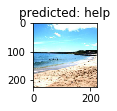

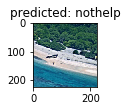

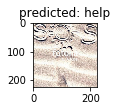

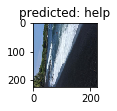

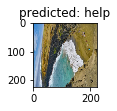

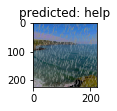

In [13]:
visualize_model(model_ft)

In [14]:
torch.save(model_ft.state_dict, 'resnet18_0')

In [15]:
from utils.load_data import load_data

In [17]:
dataloaders, dataset_sizes, class_names = load_data('../data')

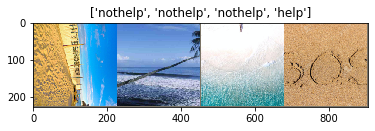

In [18]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [19]:
images = images.to(device)
outputs = model_ft(images)

In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s'%class_names[predicted[j]] for j in range(2)))

Predicted:   help  help


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
len_test = dataset_sizes['test']
print(f'Accuracy of the network on {len_test} the test images: {100*correct/total:.2f}') 

Accuracy of the network on 540 the test images: 48.89
